# I. Camera Calibration

In [1]:
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

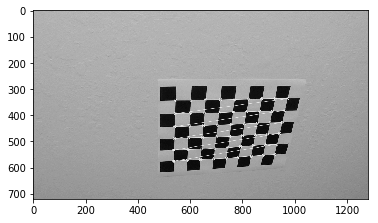

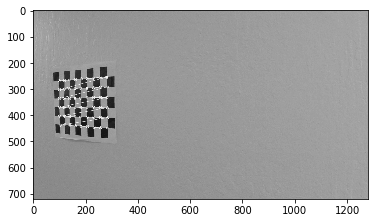

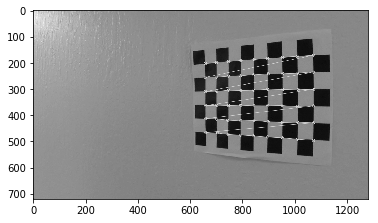

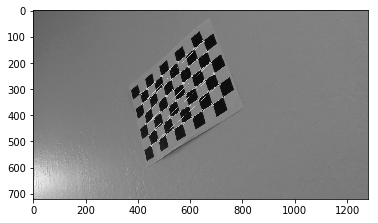

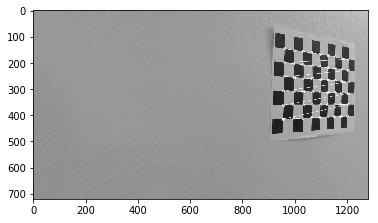

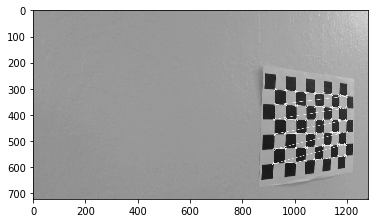

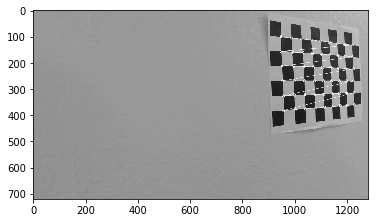

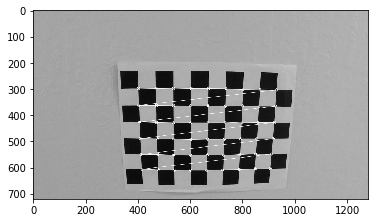

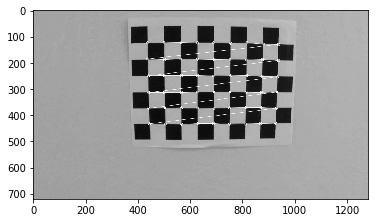

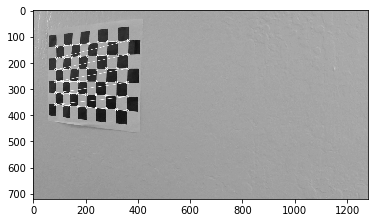

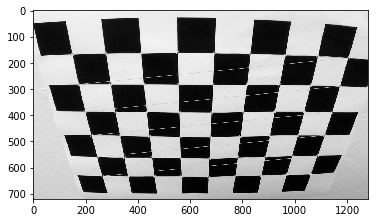

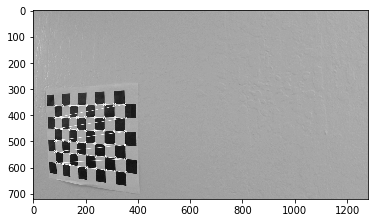

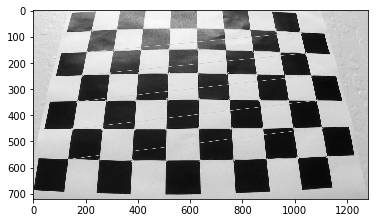

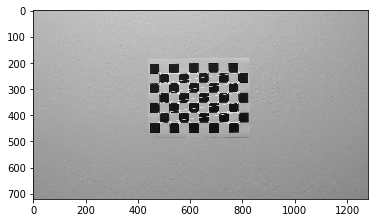

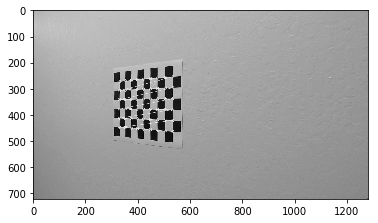

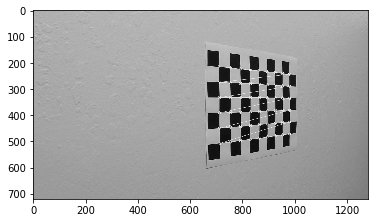

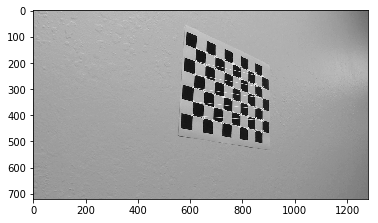

In [2]:
# Object points expected (0, 0, 0), (1, 0, 0), (2, 0, 0)...
object_point_grid = np.zeros((6*9, 3), np.float32)
object_point_grid[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)

# Buffer for object points and image points
object_points = []
image_points = []

# Get the calibration imagery
calibration_images = glob.glob('camera_cal/calibration*.jpg')

# Accumulate the image points and display calibration images with corners identified
for calibration_image_path in calibration_images:
    calibration_image = cv2.imread(calibration_image_path)
    calibration_image_grayscaled = cv2.cvtColor(calibration_image, cv2.COLOR_BGR2GRAY)
    
    ok, chessboard_corners = cv2.findChessboardCorners(calibration_image_grayscaled, (9, 6), None)
    
    if ok:
        object_points.append(object_point_grid)
        image_points.append(chessboard_corners)
        
        calibration_image_with_corners = cv2.drawChessboardCorners(
            calibration_image_grayscaled,
            (9, 6),
            chessboard_corners,
            ok
        )
        plt.imshow(calibration_image_with_corners, cmap='gray')
        plt.figure()
        

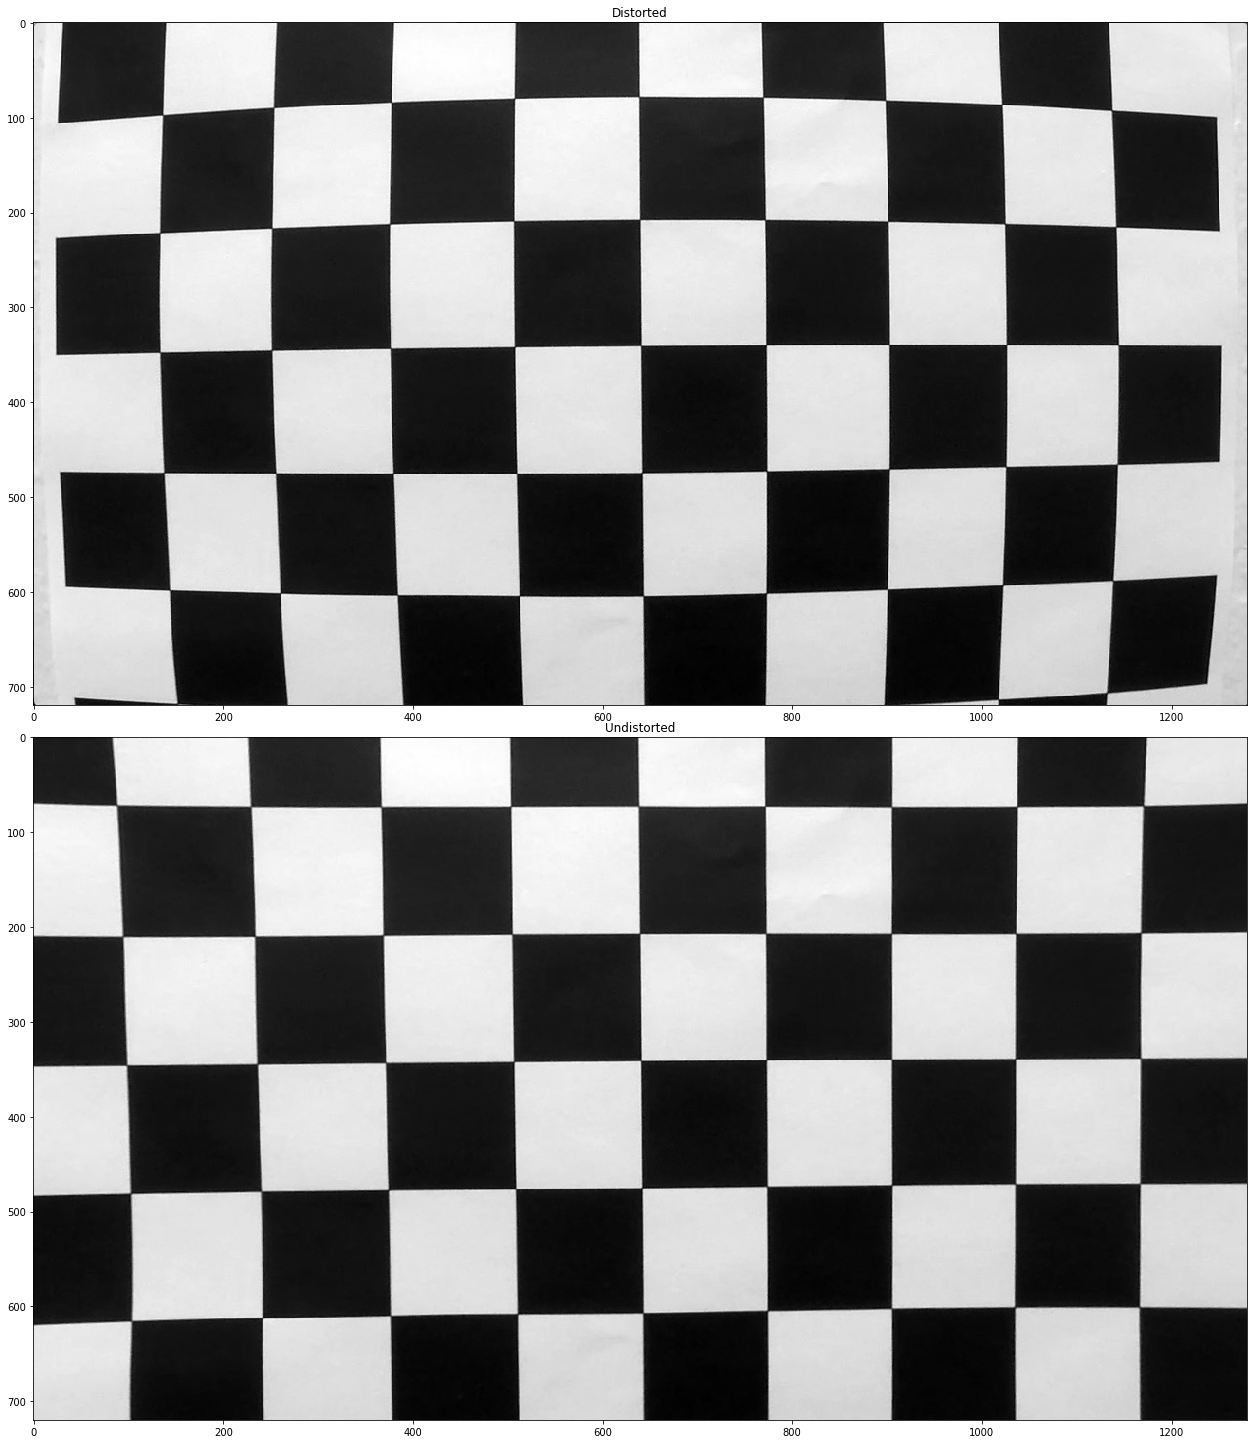

In [3]:
# Find the camera distortion from the image points discovered above
ok, camera_matrix, distortion_coeffs, rvecs, tvecs = cv2.calibrateCamera(
    object_points,
    image_points,
    (720, 1280),
    None,
    None,
)

# Create an example image with an undistortion operation applied
example_distorted_image = cv2.imread('camera_cal/calibration1.jpg')
example_distorted_image_grayscaled = cv2.cvtColor(example_distorted_image, cv2.COLOR_BGR2GRAY)
example_undistorted_image = cv2.undistort(
    example_distorted_image_grayscaled,
    camera_matrix,
    distortion_coeffs
)

# Display our example images
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 20))
f.tight_layout()
ax1.set_title("Distorted")
ax1.imshow(example_distorted_image_grayscaled, cmap='gray')
ax2.set_title("Undistorted")
ax2.imshow(example_undistorted_image, cmap='gray')

# II. Image Processing Pipeline

## 1. Distortion Correction

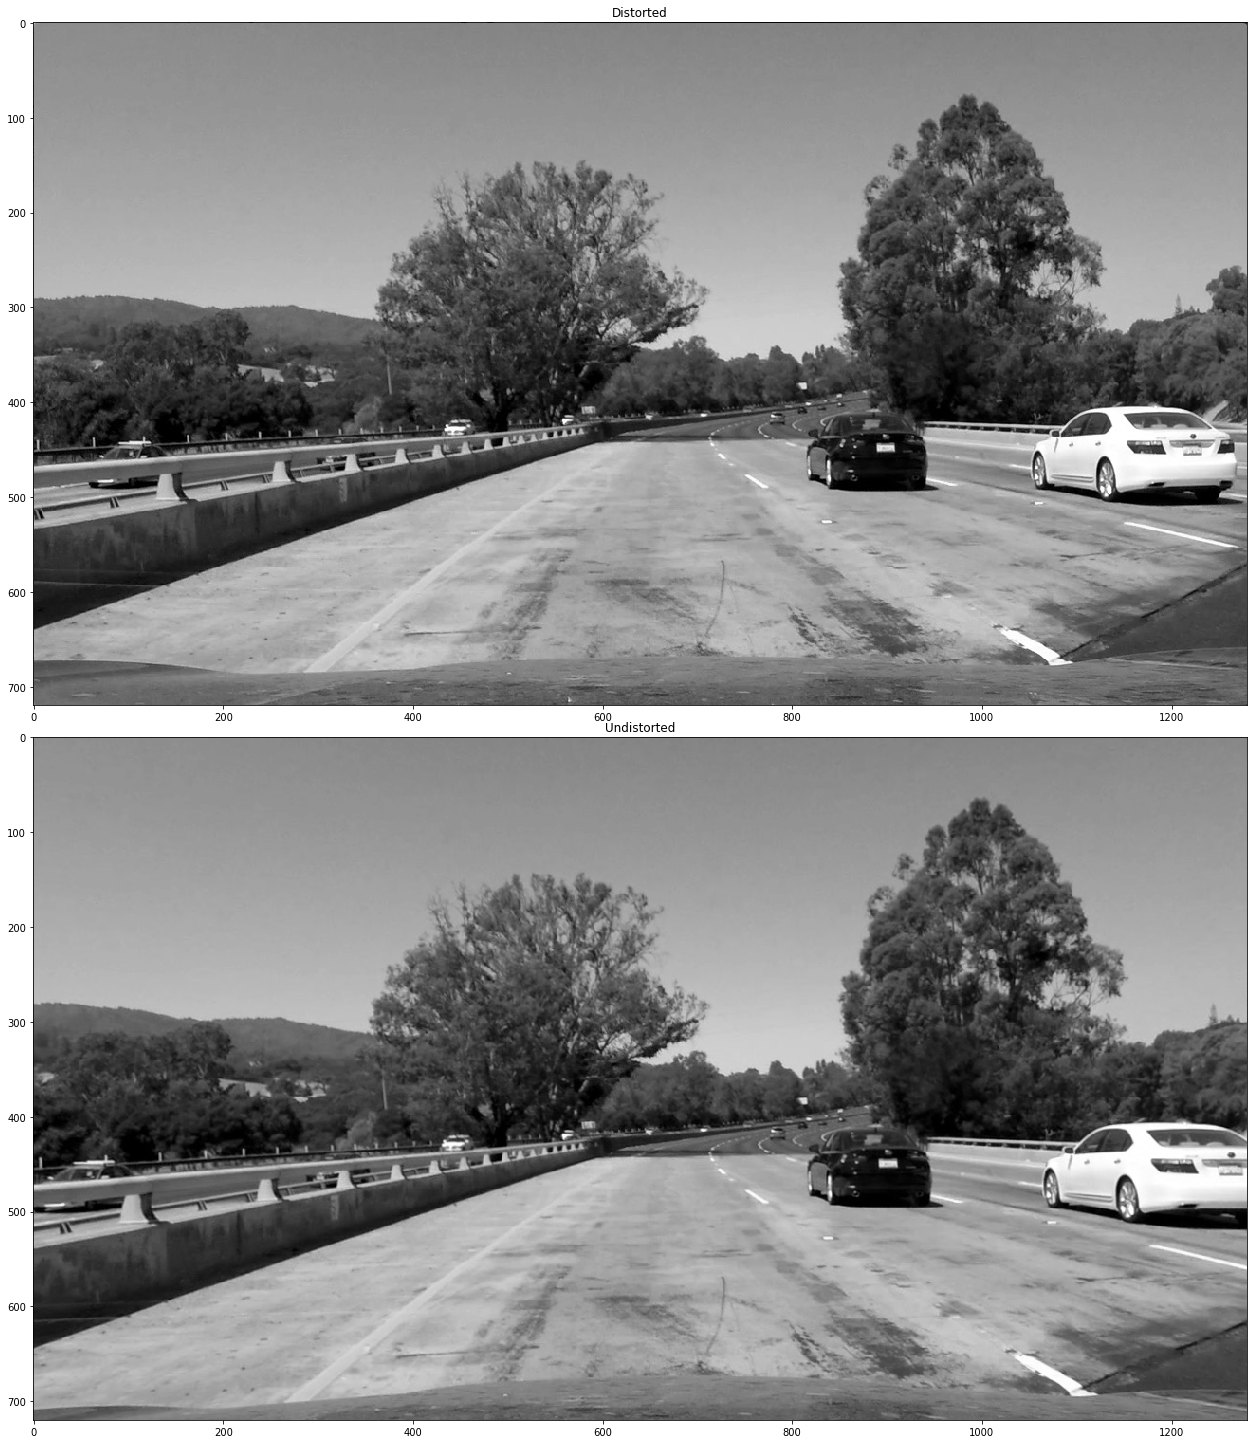

In [4]:
# Get a test image to undistort
example_distorted_test_image = cv2.imread('test_images/test1.jpg')
example_distorted_test_image_grayscaled = cv2.cvtColor(example_distorted_test_image, cv2.COLOR_BGR2GRAY)
example_undistorted_test_image = cv2.undistort(
    example_distorted_test_image_grayscaled,
    camera_matrix,
    distortion_coeffs
)

# Display the distorted test alongside its undistorted counterpart
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 20))
f.tight_layout()
ax1.set_title("Distorted")
ax1.imshow(example_distorted_test_image_grayscaled, cmap='gray')
ax2.set_title("Undistorted")
ax2.imshow(example_undistorted_test_image, cmap='gray')

## 2. Color Transforms & Gradient Thresholding

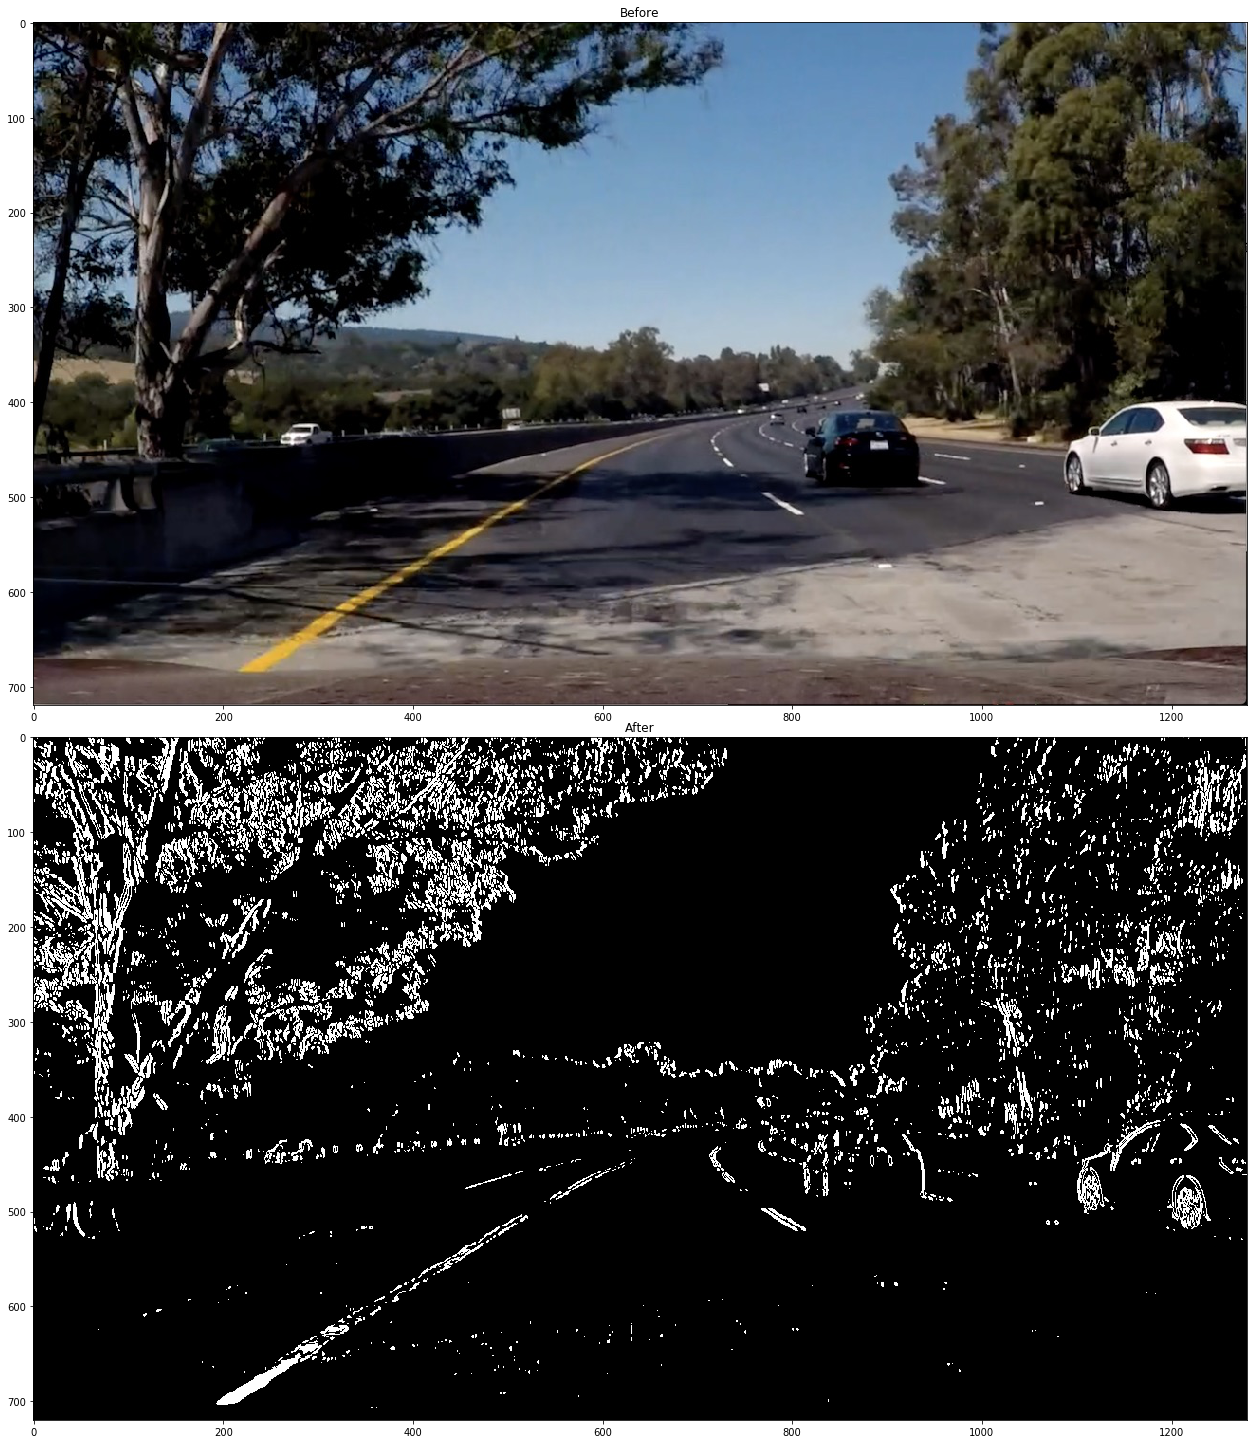

In [170]:
# We'll continue using the example from above
example_distorted_test_image = cv2.imread('trouble.jpg')
example_undistorted_test_image = cv2.undistort(
    example_distorted_test_image,
    camera_matrix,
    distortion_coeffs
)

def generate_binary_image(image, sobel_thresholds=(30, 140), color_thresholds=(150, 255)):
    # Convert to HLS color space
    hls_test_image = cv2.cvtColor(
        image,
        cv2.COLOR_RGB2HLS,
    )

    # Grab the S channel for separate usage
    s_channel = hls_test_image[:,:,2]
    l_channel = hls_test_image[:,:,1]

    # Also get a grayscaled version of the image
    grayscaled_test_image = cv2.cvtColor(
        image,
        cv2.COLOR_RGB2GRAY,
    )

    # Do the Sobel filter
    sobel_x = cv2.Sobel(
        grayscaled_test_image,
        cv2.CV_64F,
        1,
        0,
    )
    absolute_sobel_x = np.absolute(sobel_x)
    scaled_sobel_x = np.uint8(255*absolute_sobel_x/np.max(absolute_sobel_x))

    # Thresholding on the x gradient
    sobel_x_binary = np.zeros_like(scaled_sobel_x)
    sobel_x_binary[(scaled_sobel_x >= sobel_thresholds[0]) & (scaled_sobel_x <= sobel_thresholds[1])] = 1

    # Thresholding on the color channels
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= color_thresholds[0]) & (s_channel <= color_thresholds[1])] = 1
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= 60) & (l_channel <= 230)] = 1

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sobel_x_binary)
    combined_binary[(sobel_x_binary == 1) | ((s_binary == 1) & (l_binary == 1))] = 1
    return combined_binary

# Display the before and after
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 20))
f.tight_layout()
ax1.set_title("Before")
ax1.imshow(cv2.cvtColor(example_distorted_test_image, cv2.COLOR_BGR2RGB))
ax2.set_title("After")
ax2.imshow(generate_binary_image(example_undistorted_test_image), cmap='gray')

## 3. Perspective Transform

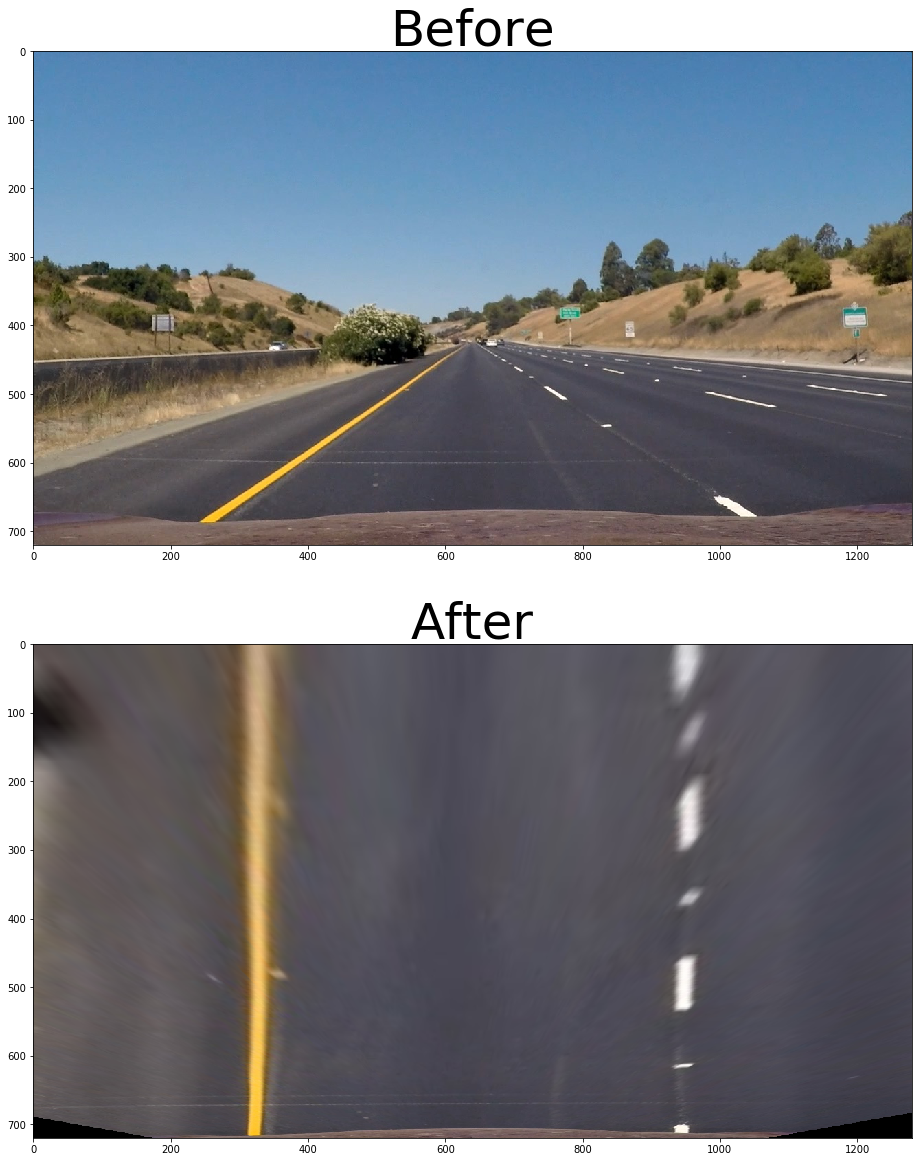

In [171]:
# We'll continue using the example from above
example_distorted_test_image = cv2.imread('test_images/straight_lines1.jpg')
example_undistorted_test_image = cv2.undistort(
    example_distorted_test_image,
    camera_matrix,
    distortion_coeffs
)

def warper(image):
    image_size = image.shape[:2]
    img_size = (image_size[1], image_size[0])
    src = np.float32(
        [[(img_size[0] / 2) - 45, img_size[1] / 2 + 90],
        [((img_size[0] / 6) - 10), img_size[1]],
        [(img_size[0] * 5 / 6) + 60, img_size[1]],
        [(img_size[0] / 2 + 45), img_size[1] / 2 + 90]])
    dst = np.float32(
        [[(img_size[0] / 4), 0],
        [(img_size[0] / 4), img_size[1]],
        [(img_size[0] * 3 / 4), img_size[1]],
        [(img_size[0] * 3 / 4), 0]])
    perspective_matrix = cv2.getPerspectiveTransform(src, dst)
    inverse_warp_matrix = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(image, perspective_matrix, img_size)
    return warped, inverse_warp_matrix


# Display the before and after
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 20))
ax1.set_title("Before", fontsize=50)
ax1.imshow(cv2.cvtColor(example_distorted_test_image, cv2.COLOR_BGR2RGB))
ax2.set_title("After", fontsize=50)
ax2.imshow(cv2.cvtColor(warper(example_undistorted_test_image)[0], cv2.COLOR_BGR2RGB))





## 4. Identify lane-line pixels and fit a polynomial

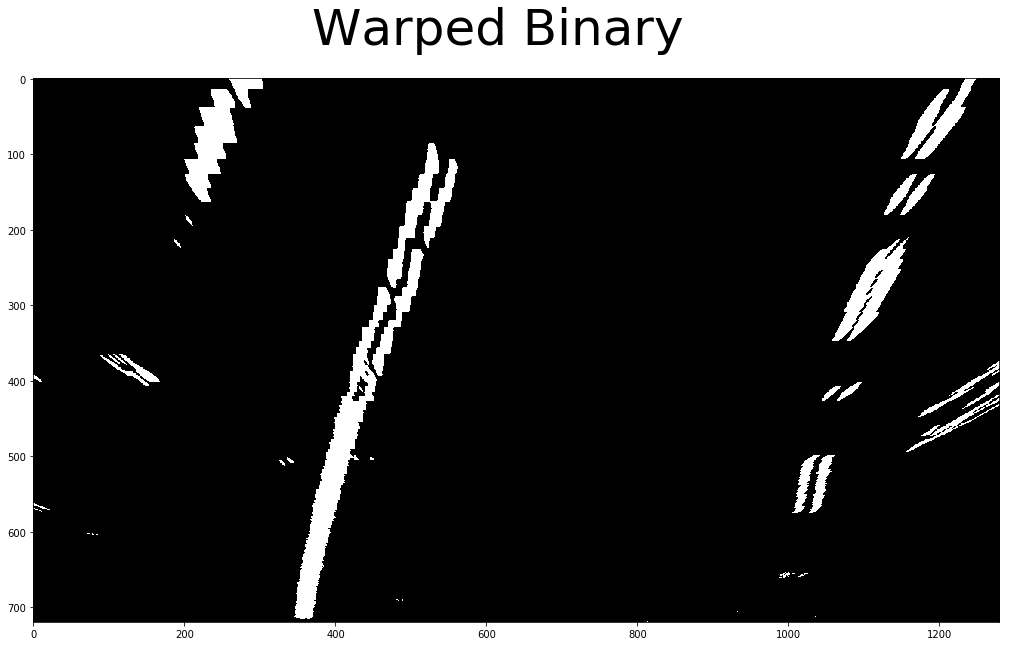

In [172]:
# We'll continue using the example from above
example_distorted_test_image = cv2.imread('test_images/test6.jpg')
example_undistorted_test_image = cv2.undistort(
    example_distorted_test_image,
    camera_matrix,
    distortion_coeffs
)

# At this step we need the binary image
binary = generate_binary_image(example_undistorted_test_image)

# Here's what that looks like warped
warped = warper(binary)[0]
fig = plt.figure(figsize=(20, 10))
fig.suptitle("Warped Binary", fontsize=50)
plt.imshow(warped, cmap='gray')

In [260]:
def windowed_lane_search(image, left_fit, right_fit):
    output_buffer = np.dstack((image, image, image))*255
    
    # Get a histogram of the bottom half of the image
    histogram = np.sum(image[np.int(image.shape[0] / 2):, :], axis=0)
#     plt.figure()
#     plt.plot(histogram)

    # Discover some sane starting points for the left and right lanes
    midpoint = np.int(histogram.shape[0]/2)
    left_x_base = np.argmax(histogram[:midpoint])
    right_x_base = np.argmax(histogram[midpoint:]) + midpoint

    num_windows = 9
    window_height = np.int(warped.shape[0]/num_windows)

    # x/y positions of all nonzeros in the image
    nonzero = warped.nonzero()
    nonzero_y = np.array(nonzero[0])
    nonzero_x = np.array(nonzero[1])

    # Position buffers for use when moving from window to window
    # Starts at our sane starting points
    current_left_x = left_x_base
    current_right_x = right_x_base

    # How much margine on each side of each window?
    margin = 100

    # Minimum number of pixels needed to recenter a window?
    recenter_minimum = 50

    # Buffers for left and right lane pixel indices
    left_lane_indices = []
    right_lane_indices = []

    for window in range(num_windows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = image.shape[0] - (window + 1) * window_height
        win_y_high = image.shape[0] - window * window_height
        win_xleft_low = current_left_x - margin
        win_xleft_high = current_left_x + margin
        win_xright_low = current_right_x - margin
        win_xright_high = current_right_x + margin
        # Draw the windows on the visualization image
        cv2.rectangle(
            output_buffer,
            (win_xleft_low, win_y_low),
            (win_xleft_high, win_y_high),
            (0, 255, 0),
            2
        ) 
        cv2.rectangle(
            output_buffer,
            (win_xright_low, win_y_low),
            (win_xright_high, win_y_high),
            (0, 255, 0),
            2
        ) 
        # Identify the nonzero pixels in x and y within the window
        good_left_indices = (
            (nonzero_y >= win_y_low) & 
            (nonzero_y < win_y_high) & 
            (nonzero_x >= win_xleft_low) & 
            (nonzero_x < win_xleft_high)).nonzero()[0]
        good_right_indices = (
            (nonzero_y >= win_y_low) & 
            (nonzero_y < win_y_high) & 
            (nonzero_x >= win_xright_low) & 
            (nonzero_x < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_indices.append(good_left_indices)
        right_lane_indices.append(good_right_indices)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_indices) > recenter_minimum:
            current_left_x = np.int(np.mean(nonzero_x[good_left_indices]))
        if len(good_right_indices) > recenter_minimum:        
            current_right_x = np.int(np.mean(nonzero_x[good_right_indices]))
            
    left_lane_indices = np.concatenate(left_lane_indices)
    right_lane_indices = np.concatenate(right_lane_indices)
    
    left_x = nonzero_x[left_lane_indices]
    left_y = nonzero_y[left_lane_indices]
    right_x = nonzero_x[right_lane_indices]
    right_y = nonzero_y[right_lane_indices]
    
    try:
        new_left_fit = np.polyfit(left_y, left_x, 2)
    except TypeError:
        new_left_fit = left_fit
    try:
        new_right_fit = np.polyfit(right_y, right_x, 2)
    except TypeError:
        new_right_fit = right_fit
    
    # Do visualization

    output_buffer[nonzero_y[left_lane_indices], nonzero_x[left_lane_indices]] = [255, 0, 0]
    output_buffer[nonzero_y[right_lane_indices], nonzero_x[right_lane_indices]] = [0, 0, 255]
    
    return new_left_fit, new_right_fit, output_buffer, right_x, right_y, left_x, left_y

def preexisting_lane_search(image, left_fit, right_fit):
    nonzero = image.nonzero()
    nonzero_y = np.array(nonzero[0])
    nonzero_x = np.array(nonzero[1])
    margin = 100
    left_lane_indices = ((nonzero_x > (left_fit[0]*(nonzero_y**2) + left_fit[1]*nonzero_y + left_fit[2] - margin)) & (nonzero_x < (left_fit[0]*(nonzero_y**2) + left_fit[1]*nonzero_y + left_fit[2] + margin))) 
    right_lane_indices = ((nonzero_x > (right_fit[0]*(nonzero_y**2) + right_fit[1]*nonzero_y + right_fit[2] - margin)) & (nonzero_x < (right_fit[0]*(nonzero_y**2) + right_fit[1]*nonzero_y + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    left_x = nonzero_x[left_lane_indices]
    left_y = nonzero_y[left_lane_indices] 
    right_x = nonzero_x[right_lane_indices]
    right_y = nonzero_y[right_lane_indices]
    
    # Fit a second order polynomial to each
    try:
        left_fit = np.polyfit(left_y, left_x, 2)
        right_fit = np.polyfit(right_y, right_x, 2)
    except TypeError:
        left_fit, right_fit, _ = windowed_lane_search(image, left_fit, right_fit)
    
    return left_fit, right_fit, right_x, right_y, left_x, left_y

(720, 0)

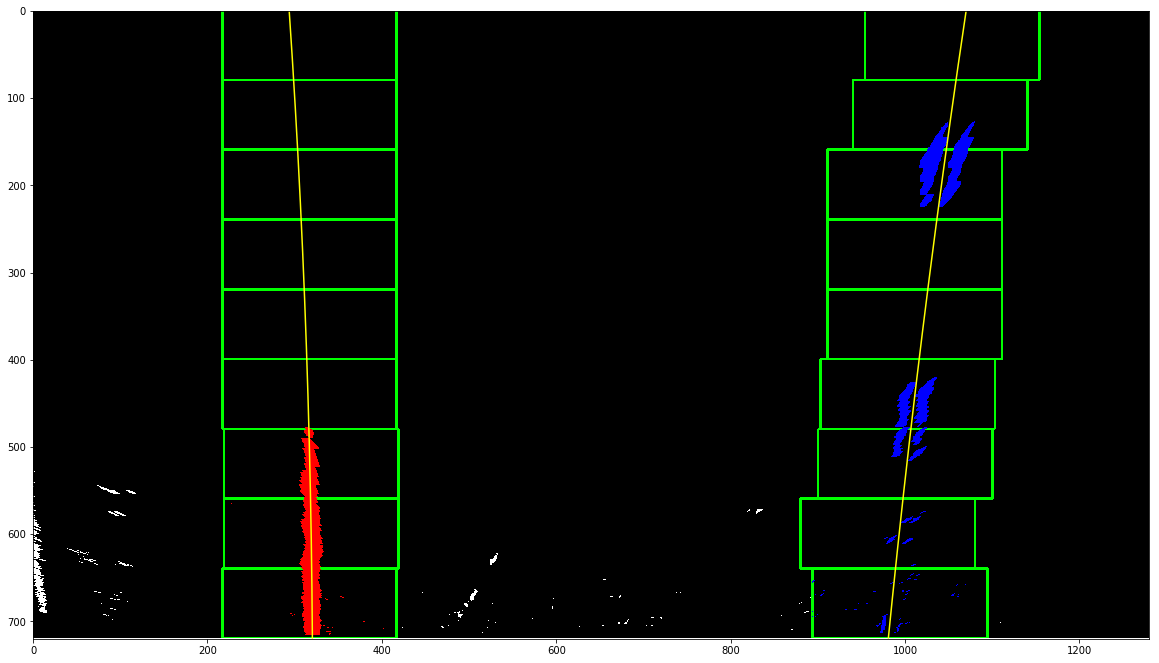

In [262]:
left_fit, right_fit, out_image, _, _, _, _ = windowed_lane_search(warped, None, None)

# Generate x and y values for plotting
ploty = np.linspace(0, out_image.shape[0]-1, out_image.shape[0] )
left_fit_x = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fit_x = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
plt.figure(figsize=(20, 20))
plt.imshow(out_image)
plt.plot(left_fit_x, ploty, color='yellow')
plt.plot(right_fit_x, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

## 5. Computing Radius of Curvature

In [275]:
meters_per_pixel_y = 30.0/720
meters_per_pixel_x = 3.7/700

def radius_of_curvature(y_value, right_x, left_x, right_y, left_y):
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(left_y*meters_per_pixel_y, left_x*meters_per_pixel_x, 2)
    right_fit_cr = np.polyfit(right_y*meters_per_pixel_y, right_x*meters_per_pixel_x, 2)
    al, bl, cl = left_fit_cr
    ar, br, cr = left_fit_cr
    left = (1 + (((2 * al * y_value * meters_per_pixel_y) + bl) ** 2) ** (1.5))/ np.absolute(2 * al)
    right = (1 + (((2 * ar * y_value * meters_per_pixel_y) + br) ** 2) ** (1.5))/ np.absolute(2 * ar)
    return left, right

def distance_from_center(left_fit, right_fit, y_value, x_size):
    left_fit_x = left_fit[0]*y_value**2 + left_fit[1]*y_value + left_fit[2]
    right_fit_x = right_fit[0]*y_value**2 + right_fit[1]*y_value + right_fit[2]
    
    center_of_car = x_size / 2
    center_of_lane = (left_fit_x + right_fit_x) / 2
    return (center_of_lane - center_of_car) * meters_per_pixel_x

## 6. Drawing Detected Lanes

In [276]:
def draw_lane_lines(warped_image, left_fit, right_fit, inverse_warp_matrix, destination_image):
    # Image for drawing
    destination_image = np.copy(destination_image)
    warp_zero = np.zeros_like(warped_image).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    
    ploty = np.linspace(0, warp_zero.shape[0]-1, warp_zero.shape[0] )
    left_fit_x = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fit_x = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Convert x & y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fit_x, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fit_x, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, inverse_warp_matrix, (warp_zero.shape[1], warp_zero.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(destination_image, 1, newwarp, 0.3, 0)
    
    return result
    
import datetime
    
def draw_radius_of_curvature(image, radius, last_draw):
    
    if (datetime.datetime.now() - last_draw).total_seconds() > 1:
        last_draw = datetime.datetime.now()
        radius = min_radius
    
    cv2.putText(
        image,
        "Radius of Curvature: {radius} m".format(radius=round(radius, 3)),
        (10, 50),
        cv2.FONT_HERSHEY_SIMPLEX,
        1.1,
        (255, 255, 255),
        2,
    )
    return last_draw

def draw_center_offset(left_fit, right_fit, image):
    y_value = image.shape[0]
    distance = distance_from_center(left_fit, right_fit, y_value, image.shape[1])
    
    cv2.putText(
        image,
        "Offset from center of lane: {distance} m".format(distance=round(distance, 3)),
        (10, 150),
        cv2.FONT_HERSHEY_SIMPLEX,
        1.1,
        (255, 255, 255),
        2,
    )
    

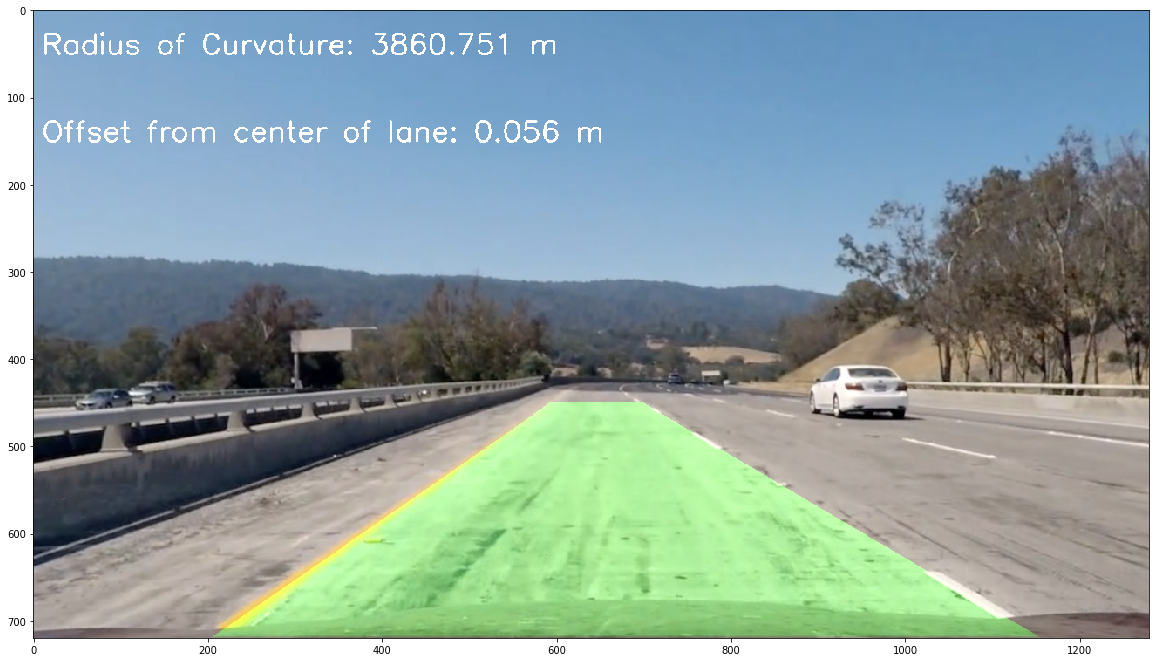

In [277]:
# We'll continue using the example from above
example_distorted_test_image = cv2.imread('trouble3.jpg')
example_undistorted_test_image = cv2.undistort(
    example_distorted_test_image,
    camera_matrix,
    distortion_coeffs
)
example_undistorted_test_image = cv2.cvtColor(example_undistorted_test_image, cv2.COLOR_BGR2RGB)

# At this step we need the binary image
binary = generate_binary_image(example_undistorted_test_image)

# Here's what that looks like warped
warped, inverse_warp_matrix = warper(binary)

left_fit, right_fit, _, right_x, right_y, left_x, left_y = windowed_lane_search(warped, None, None)

new_image = draw_lane_lines(warped, left_fit, right_fit, inverse_warp_matrix, example_undistorted_test_image)

last_draw = datetime.datetime.now()
y_value = new_image.shape[0]
radius_left, radius_right = radius_of_curvature(y_value, right_x, left_x, right_y, left_y)

min_radius = min([radius_left, radius_right])

last_draw = draw_radius_of_curvature(new_image, min_radius, last_draw)
draw_center_offset(left_fit, right_fit, new_image)

plt.figure(figsize=(20, 20))
plt.imshow(new_image)

# III. Pipelining for Video

In [284]:
global last_5_radius
last_5_radius = []
def lane_detector_pipeline(image, left, right):
    image = np.copy(image)
    undistorted_image = cv2.undistort(
        image,
        camera_matrix,
        distortion_coeffs
    )
    binary = generate_binary_image(undistorted_image)
    warped, inverse_warp_matrix = warper(binary)
    if left == None and right == None:
        left_fit, right_fit, _, right_x, right_y, left_x, left_y = windowed_lane_search(warped, left, right)
    else:
        left_fit, right_fit, right_x, right_y, left_x, left_y = preexisting_lane_search(warped, left, right)
    drawn = draw_lane_lines(
        warped,
        left_fit,
        right_fit,
        inverse_warp_matrix,
        undistorted_image
    )
    last_draw = datetime.datetime.now()
    y_value = new_image.shape[0]
    min_radius = min(radius_of_curvature(y_value, right_x, left_x, right_y, left_y))


    if len(last_5_radius) == 5:
        last_5_radius.pop()
    last_5_radius.insert(0, min_radius)

    last_draw = draw_radius_of_curvature(drawn, sum(last_5_radius) / len(last_5_radius), last_draw)
    draw_center_offset(left_fit, right_fit, drawn)
#     plt.figure()
#     plt.imshow(drawn)
    return drawn, left_fit, right_fit


In [285]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [286]:
class ImageProcessor:
    per_image_fit_left = None
    per_image_fit_right = None
    def process_image(self, image):
        drawn, self.per_image_fit_left, self.per_image_fit_right = lane_detector_pipeline(image, self.per_image_fit_left, self.per_image_fit_right)
        return drawn

processor = ImageProcessor()
    
output = 'project_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
project_clip = clip1.fl_image(processor.process_image) #NOTE: this function expects color images!!
%time project_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_output.mp4
[MoviePy] Writing video project_output.mp4


100%|█████████▉| 1260/1261 [03:01<00:00,  6.57it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output.mp4 

CPU times: user 3min 19s, sys: 37.6 s, total: 3min 56s
Wall time: 3min 2s


In [287]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))